In [1]:
import os
import sys
import pickle
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime, timedelta
import json
from abc import ABCMeta, abstractmethod
import boto3
# import snowflake.connector
from io import StringIO
import logging 
from scipy.optimize import curve_fit
from scipy.stats import percentileofscore


logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from utils import *

class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model    

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError

        
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx

    
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    return df

import plotly.express as px
def get_simple_plot(df_plt, x, y, grpby, text, title=''):
    if title=='':
        title = f'{y} vs {x}'
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  color=grpby, 
                  hover_data=[text],
                  width=800, height=400)
    fig.show()
    return 


## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
# conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
# ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
# cur = ctx.cursor()

input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"
key_path = 'cost_allocation/dev'

INFO:root:Starting Notebook
INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


## SVOD Monthly, Retail,  domestic

In [50]:
def exponential_decay(x, a, b,c):
    return a * np.exp(b * x) + c

def exponential_decay_slope(x, a, b):
    return a * b*np.exp(b * x)

def fit_exponential(x_data, y_data, p0, param_bounds):
    x_fit = np.linspace(0, x_data.max(), 100)   
    params, _ = curve_fit(exponential_decay, np.array(x_data), y_data, p0, bounds=param_bounds)
    return x_fit, params


def get_churn_bin(df_in, grpby):
    df = df_in.groupby(by=['hbo_uuid','sub_month']+ grpby +['is_cancel']).sum().reset_index()
    df = df_in[df_in.monthly_hours_viewed<=60]
    nbins = 100
    df['hours_viewed_bin'] = pd.qcut(df['monthly_hours_viewed'], np.linspace(0,1,nbins), duplicates='drop')
    df['hours_viewed_bin'] = df['hours_viewed_bin'].apply(lambda x: (x.left+x.right)/2)
    df['hours_viewed_bin'] = df['hours_viewed_bin'].astype('float')
    df['churn'] = 1*df['is_cancel']  
    
    df_bin = df.groupby(['hours_viewed_bin']+grpby).agg({'churn':'mean', 'hbo_uuid':'count',
                                                         'is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()
    return(df_bin)



def get_df_60_h(list_df):
    df_list=[]
    num=0
    for df_test in list_df:
        df_test['num_df'] = num
        df_list.append(df_test)
        num=num+1
    return(df_list)


def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
    if title=='':
        
        title = f'{y} vs {x}'
       
    a_fit, b_fit, c_fit = params
    annotation_x_loc = 50
    annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=500, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis=dict(range=[0,50]),
        annotations=[
        dict(
            x=annotation_x_loc,  # x-coordinate for the text
            y=annotation_y_loc,  # y-coordinate for the text
            text='y= {:.2f} * e^({:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
            showarrow=False,  # disable arrow for the annotation
            xanchor='right',
            font=dict(
                family='Arial',  # specify font family
                size=18,  # specify font size
                color='black'  # specify font color
            )
        )
    ]
) 
    fig.show()
    return 

def get_simple_plot_multiple_dot(df_plt, x, y, x_fit, y_fit, params, x_med, y_med, title=''):
    if title=='':
        
        title = f'{y} vs {x}'
       
    a_fit, b_fit, c_fit = params
    print('y= {:.2f} * e^({:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit))
    print('y= {:.3f} * e^({:.2f} * hours_viewed)'.format(a_fit*b_fit,b_fit))
    annotation_x_loc = 50
    annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=500, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)
    
    fig.add_scatter( 
              x=x_med, 
              y=y_med,
                mode='markers',
            marker=dict(size=14, color='red', line=dict(color='black', width=2)))

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis=dict(range=[0,50]),
        annotations=[
        dict(
            x=x_med+0.2,  # x-coordinate for the text
            y=y_med+0.01,  # y-coordinate for the text
            text='{:.2f}, {:.2f}'.format(x_med, y_med),  # the text to display
            showarrow=False,  # disable arrow for the annotation
            xanchor='left',
            font=dict(
                family='Arial',  # specify font family
                size=18,  # specify font size
                color='black'  # specify font color
            )
        )
    ]
) 
    fig.show()
    return fig



def get_churn_plot_simple(df_i, title, param_dic, x_med=0):
    df_i = df_i[df_i.is_cancel>=20]
#         display(df_i.tail(5))

    x_var = df_i.hours_viewed_bin
    y_data = df_i.churn
    p0 = [0.5, -0.1, 0.01] 
    param_bounds = ([0, -0.8, 0.01], [np.inf, -0.1, np.inf])

    x_fit, params = fit_exponential(x_var, y_data, p0, param_bounds)
    a_fit, b_fit, c_fit = params
    y_fit = exponential_decay(x_fit, a_fit, b_fit, c_fit)
    
    if x_med==0:
        fig = get_simple_plot_multiple(df_i, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, f'{title}')
    else:
        y_med = exponential_decay(x_med, a_fit, b_fit, c_fit)
        print(x_med)
        print(y_med)
        fig = get_simple_plot_multiple_dot(df_i, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, x_med, np.array(y_med), f'{title}')
    display(df_i.head())
    param_dic['acquired'] = params
    return fig, params



def get_simple_plot_dot(df_plt, x, y, x_fit, y_fit, params, x_med, y_med, title=''):
    if title=='':
        
        title = f'{y} vs {x}'
       
    a_fit, b_fit, c_fit = params
    print('y= {:.2f} * e^({:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit))
    print('y= {:.3f} * e^({:.2f} * hours_viewed)'.format(a_fit*b_fit,b_fit))
    annotation_x_loc = 50
    annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.line(x=x_fit, 
                  y=y_fit, 
                  title=title,
                  width=500, height=400)
    fig.add_scatter( 
              x=x_med, 
              y=y_med,
                mode='markers',
            marker=dict(size=14, color='red', line=dict(color='black', width=2)))

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis=dict(range=[0,50]),
        xaxis_title= "hours_viewed_bin",
        yaxis_title= "Change in churn rate (slope)",
        annotations=[
        dict(
            x=x_med+0.25,  # x-coordinate for the text
            y=y_med+0.0005,  # y-coordinate for the text
            text='{:.2f}, {:.4f}'.format(x_med, y_med),  # the text to display
            showarrow=False,  # disable arrow for the annotation
            xanchor='left',
            font=dict(
                family='Arial',  # specify font family
                size=18,  # specify font size
                color='black'  # specify font color
            )
        )
    ]
) 
    fig.show()
    return fig

def get_churn_slope_plot_simple(df_i, title, params, x_med=0):
    df_i = df_i[df_i.is_cancel>=20]
#         display(df_i.tail(5))

    x_var = df_i.hours_viewed_bin
    x_fit = np.linspace(0, x_var.max(), 100)   
    a_fit, b_fit, c_fit = params
    y_fit = exponential_decay_slope(x_fit, a_fit, b_fit)
    
    y_med = exponential_decay_slope(x_med, a_fit, b_fit)
    print(x_med)
    print(y_med)
    fig = get_simple_plot_dot(df_i, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, x_med, np.array(y_med), f'{title}')
    display(df_i.head())
    param_dic['acquired'] = params
    return fig




## EMEA markets

In [20]:
por_1 = por[0]
por_1.update({'market':'Portugal'})
spa_1 = spa[0]
spa_1.update({'market':'Spain'})
neth_1 = neth[0]
neth_1.update({'market':'Netherlands'})
nor_1 = nor[0]
nor_1.update({'market':'Nordic'})
ce_1 = ce[0]
ce_1.update({'market':'Central Europe'})

a = pd.DataFrame([por_1, spa_1, neth_1, nor_1, ce_1])
a['percentile'] = 100-a['percentile']
a['percentile'] = (a['percentile'].round(0))/100
a[['market','acquired_hr_fraction','percentile']]

n=1
por_1 = por[n]
por_1.update({'market':'Portugal'})
spa_1 = spa[n]
spa_1.update({'market':'Spain'})
neth_1 = neth[n]
neth_1.update({'market':'Netherlands'})
nor_1 = nor[n]
nor_1.update({'market':'Nordic'})
ce_1 = ce[n]
ce_1.update({'market':'Central Europe'})

b = pd.DataFrame([por_1, spa_1, neth_1,nor_1, ce_1])
b['percentile'] = 100-b['percentile']
b['percentile'] = (b['percentile'].round(0))/100
b[['market','acquired_hr_fraction','percentile']]


df_stat=pd.concat([a,b])
display(df_stat[['market','acquired_hr_fraction','percentile']])

,market,acquired_hr_fraction,percentile
0,Portugal,0.99,0.45
1,Spain,0.99,0.36
2,Netherlands,0.99,0.50
3,Nordic,0.99,0.40
4,Central Europe,0.99,0.48
0,Portugal,0.90,0.58
1,Spain,0.90,0.50
2,Netherlands,0.90,0.63
3,Nordic,0.90,0.53
4,Central Europe,0.90,0.65


In [54]:
df_spa['market'] = 'Spain'
df_por['market'] = 'Portugal'
df_nor['market'] = 'Nordic'
df_neth['market'] = 'Netherlands'
df_ce['market'] = 'Central Europe'

df = pd.concat([df_spa,df_por,df_nor,df_neth,df_ce])
df = df[['market','hours_viewed_bin','churn','hbo_uuid','is_cancel']]

df.to_csv('emea_market_churn.csv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


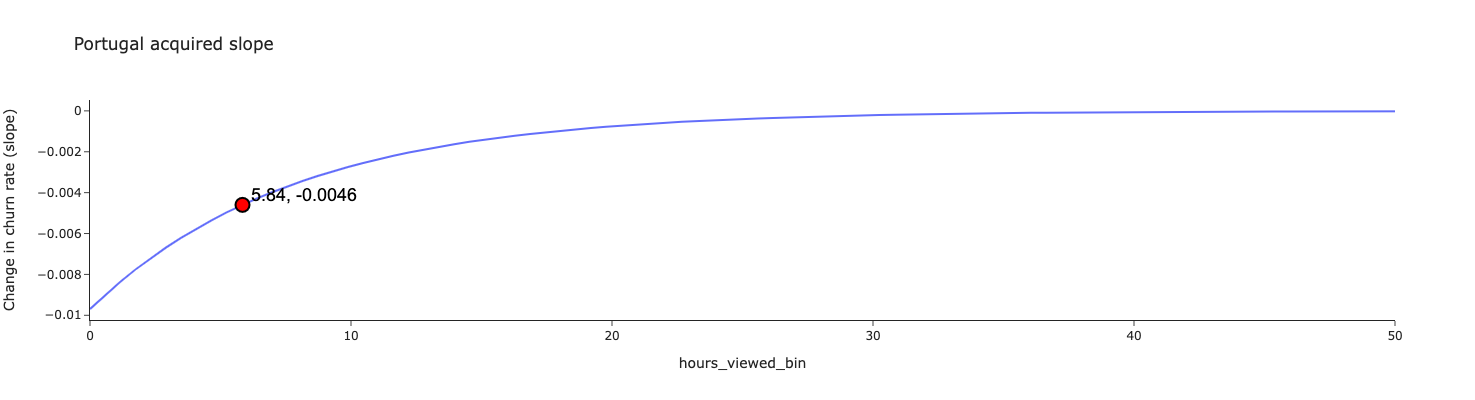

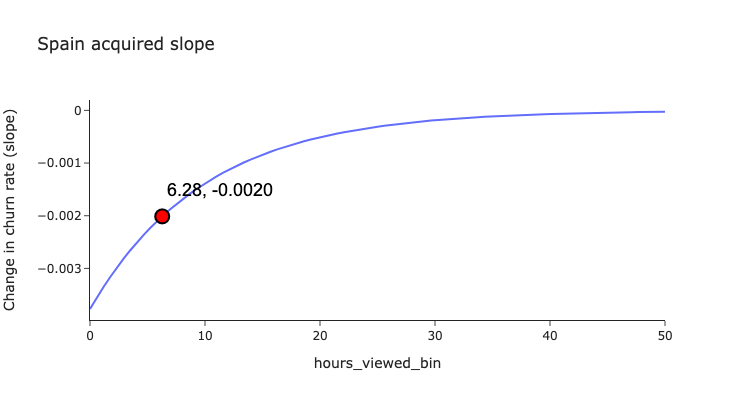

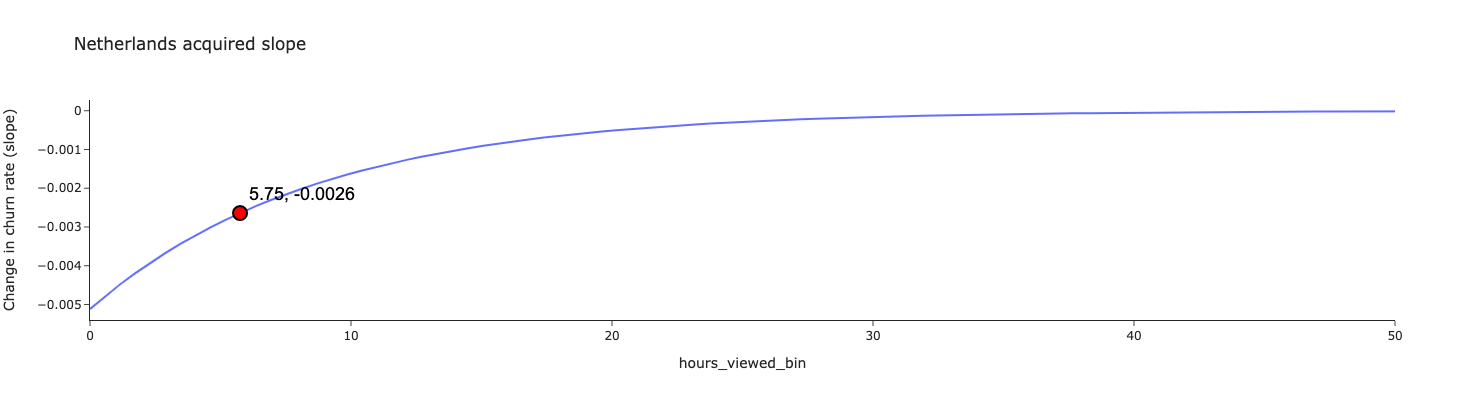

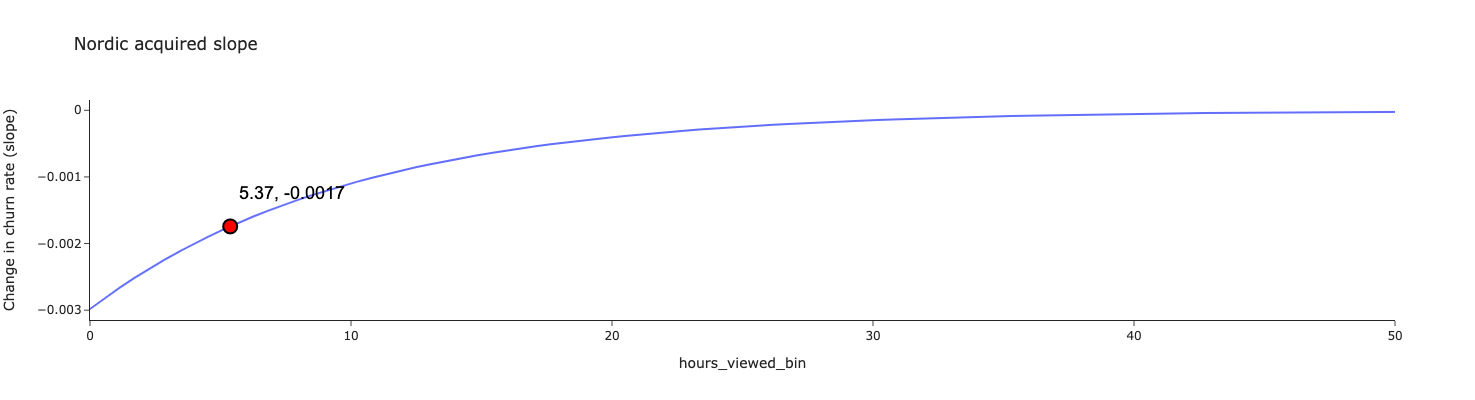

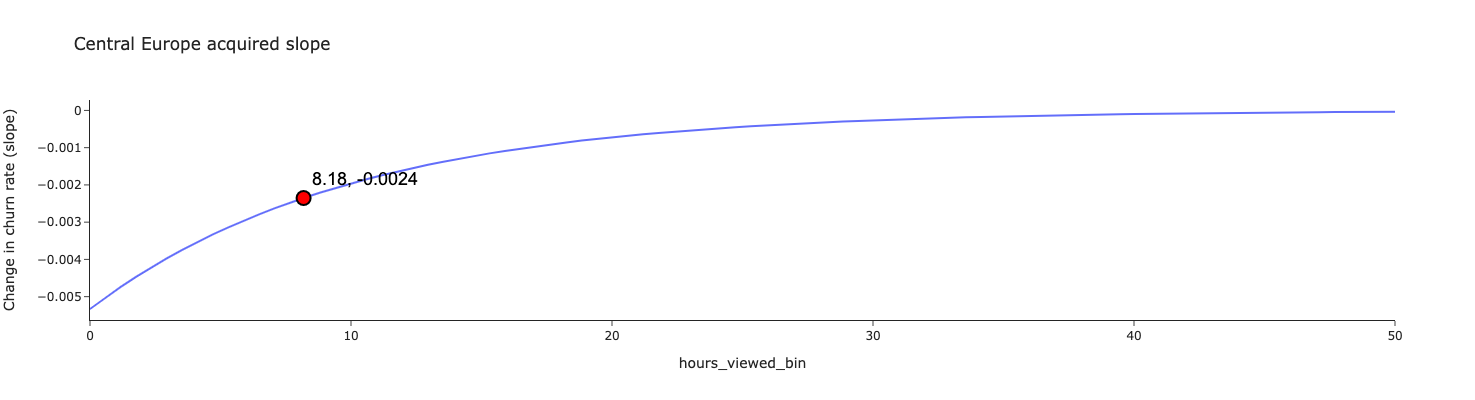

In [49]:
fig_por_slope.show()
fig_spa_slope.show()
fig_neth_slope.show()
fig_nor_slope.show()
fig_ce_slope.show()

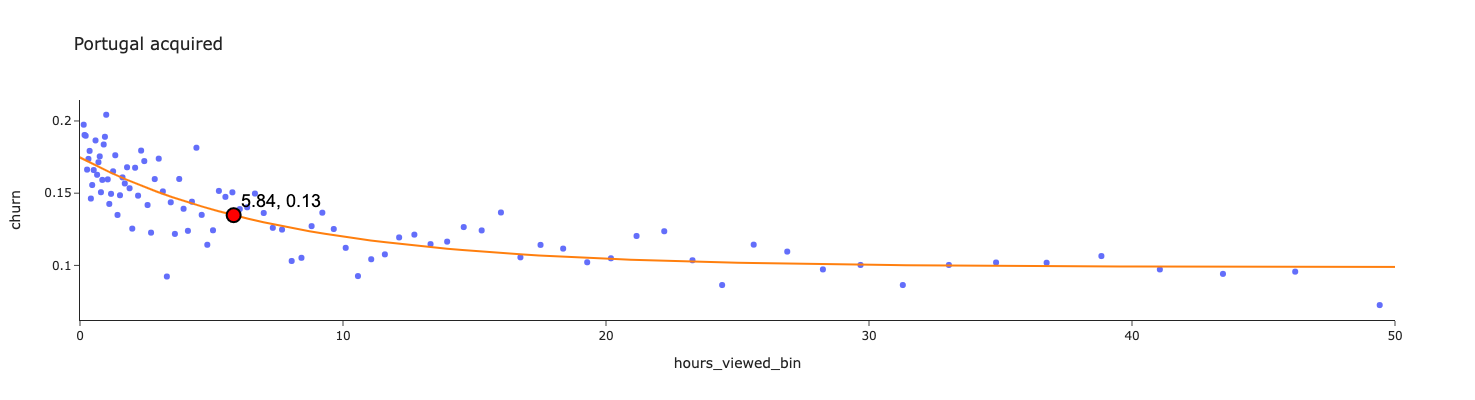

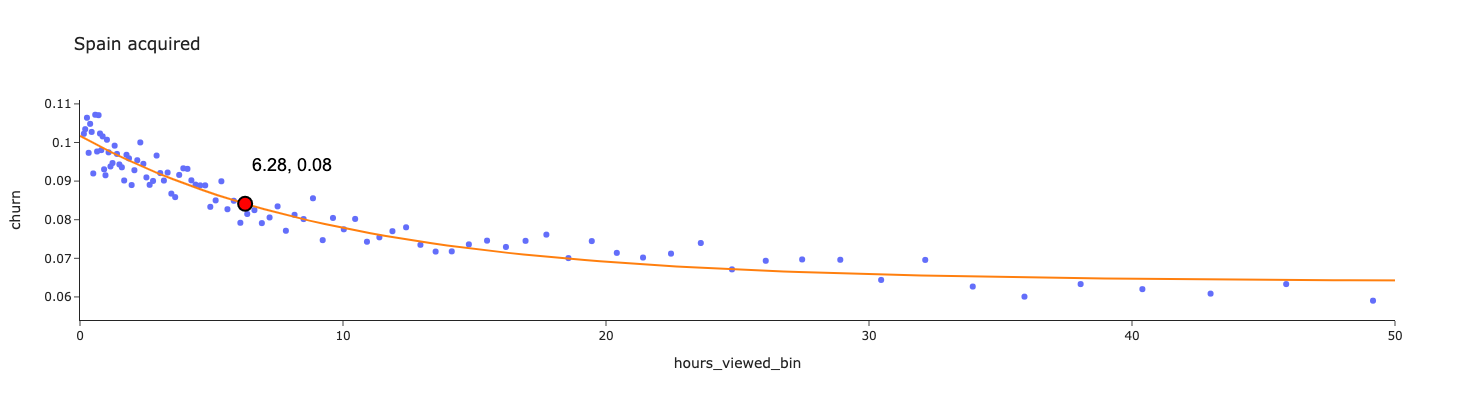

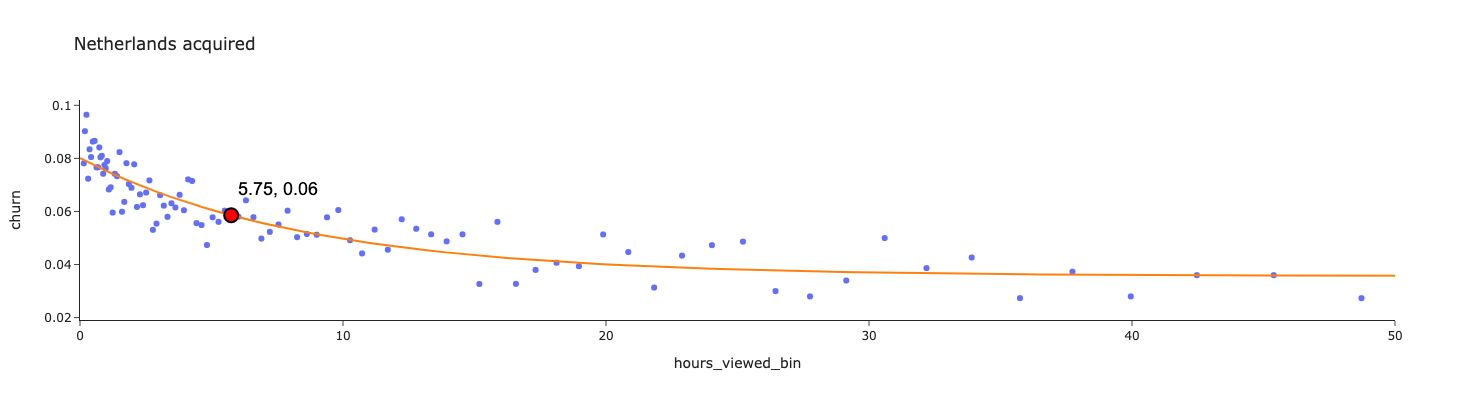

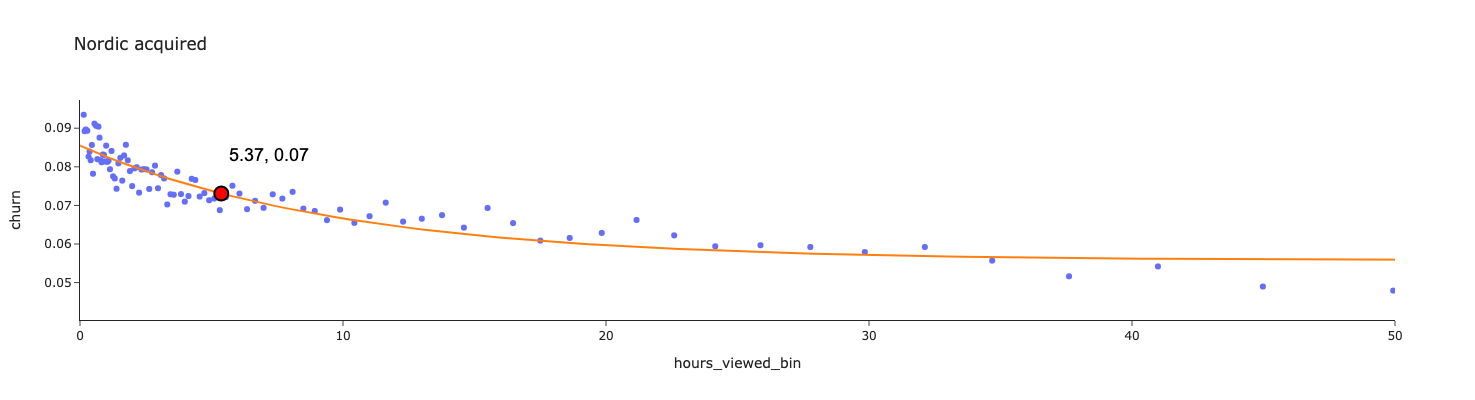

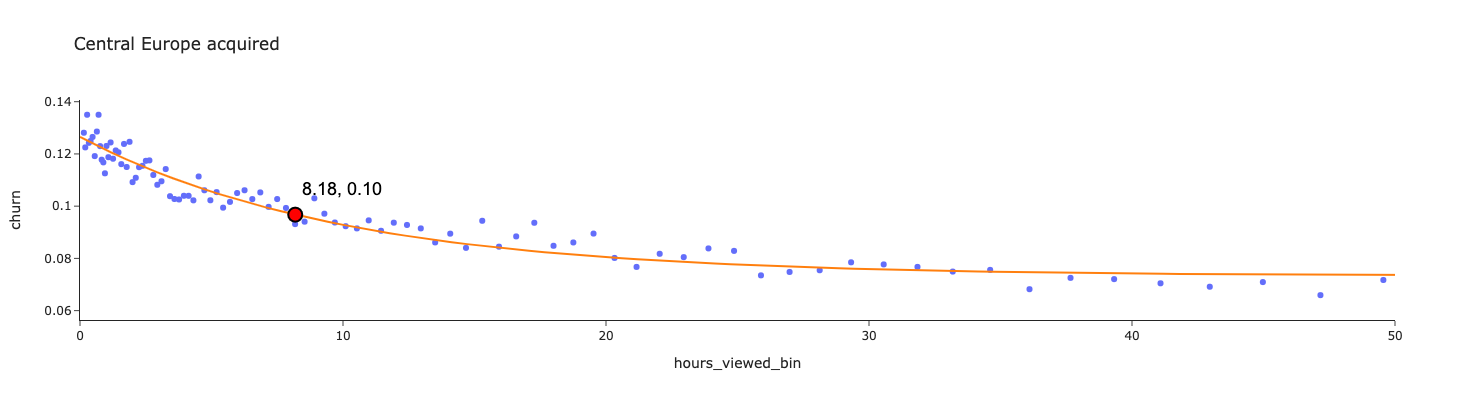

In [37]:
fig_por.show()
fig_spa.show()
fig_neth.show()
fig_nor.show()
fig_ce.show()

In [3]:
# df_60_00 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_nor_60d_20230101_full.csv')
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_nor_60d_20230301_full.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_nor_60d_20230501_full.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_nor_60d_20230701_full.csv')

# df_60_00 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_por_60d_20230101_full.csv')
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_por_60d_20230301_full.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_por_60d_20230501_full.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_por_60d_20230701_full.csv')

# df_60_00 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_spa_60d_20230101_full.csv')
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_spa_60d_20230301_full.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_spa_60d_20230501_full.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_spa_60d_20230701_full.csv')

# df_60_00 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_neth_60d_20230101_full.csv')
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_neth_60d_20230301_full.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_neth_60d_20230501_full.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_neth_60d_20230701_full.csv')

# df_60_00 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_ce_60d_20230101_full.csv')
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_ce_60d_20230301_full.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_ce_60d_20230501_full.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_ce_60d_20230701_full.csv')

def get_df_test(df_test):
    df_test['tenure_months'] = df_test['sub_month']
    df_test['monthly_hours_viewed'] = np.where(df_test['tenure_months']>1, df_test['hours_viewed']/2, df_test['hours_viewed'])
    user_total = df_test.groupby(['hbo_uuid'])['monthly_hours_viewed'].transform('sum')
    df_test['frc'] = df_test['monthly_hours_viewed'] / user_total
    
    df_test['program_type'] = np.where((df_test.program_type=='original') & (df_test.old_new=='library'), 'acquired', df_test.program_type)
    df_test = df_test[df_test.tenure_months>2]
    df_test = df_test.fillna(0)
    return(df_test)

df_60_00=get_df_test(df_60_00)
df_60_0=get_df_test(df_60_0)
df_60_1=get_df_test(df_60_1)
df_60_2=get_df_test(df_60_2)



Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_nor_60d_20230101_full.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_nor_60d_20230301_full.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_nor_60d_20230501_full.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_nor_60d_20230701_full.csv


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_nor_o_2023.pkl


hours viewed distribution


,num_df,sub_month,Unnamed: 0,hours_viewed,tenure_months,monthly_hours_viewed,frc
count,2.644400e+06,2.644400e+06,2.644400e+06,2.644400e+06,2.644400e+06,2.644400e+06,2.644400e+06
mean,1.489710e+00,1.291712e+01,3.232175e+06,3.153349e+01,3.657405e+01,1.576674e+01,9.996568e-01
std,1.117653e+00,5.516708e+00,2.021247e+06,5.100200e+01,2.579533e+01,2.550100e+01,1.413725e-02
min,0.000000e+00,3.000000e+00,5.000000e+00,2.500000e-01,3.000000e+00,1.250000e-01,1.103212e-03
25%,0.000000e+00,8.000000e+00,1.697575e+06,6.189167e+00,1.600000e+01,3.094583e+00,1.000000e+00
50%,1.000000e+00,1.400000e+01,2.926432e+06,1.573139e+01,3.200000e+01,7.865694e+00,1.000000e+00
75%,2.000000e+00,1.800000e+01,4.487885e+06,3.690840e+01,5.400000e+01,1.845420e+01,1.000000e+00
max,3.000000e+00,2.200000e+01,1.711174e+07,2.766436e+03,2.400000e+02,1.383218e+03,1.000000e+00


hours viewed breakdown median


,sub_month,num_df,Unnamed: 0,is_cancel,hours_viewed,tenure_months,monthly_hours_viewed,frc
program_type,,,,,,,,
0,14.0,0.0,1317126.0,0.0,0.823333,14.0,0.411667,0.026327
acquired,14.0,1.0,2313088.5,0.0,12.217222,24.0,6.108611,0.920973
original,14.0,1.0,1184775.0,0.0,5.953889,14.0,2.976944,0.316583


,frc
count,2.478360e+06
mean,8.005348e-01
std,2.521613e-01
min,1.103212e-03
10%,3.909163e-01
20%,5.814527e-01
25%,6.569863e-01
30%,7.231221e-01
40%,8.335936e-01
50%,9.209733e-01


(2644400, 9) 0.05627703826955075
tenure churn


,hbo_uuid,is_cancel,churn
sub_month,,,
3,473544,66793,0.141049
4,439587,52819,0.120156
5,377477,39368,0.104292
6,308552,28256,0.091576
7,263629,20885,0.079221
8,203162,14526,0.071500
9,203885,14337,0.070319
10,165207,10675,0.064616
11,179785,12434,0.069160



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

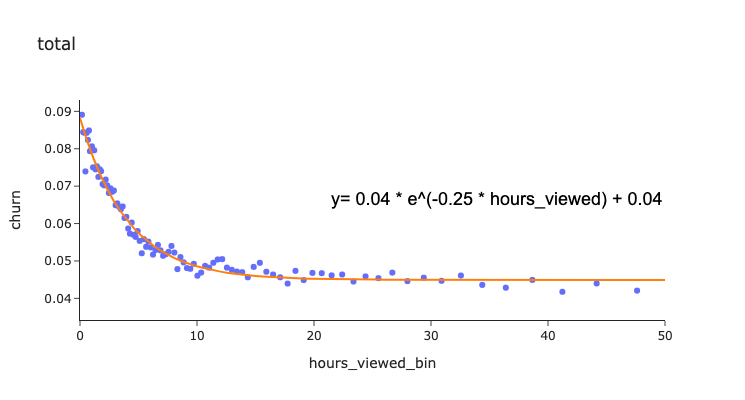

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1660,0.089092,25569,2278,4176.662361
1,0.2685,0.084445,25555,2158,6893.268611
2,0.3740,0.084293,25542,2153,9411.156389
3,0.4630,0.073936,25549,1889,11797.031944
4,0.5705,0.084246,25556,2153,14643.109861



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

5.371388887749999
0.07308631516648818
y= 0.03 * e^(-0.10 * hours_viewed) + 0.06
y= -0.003 * e^(-0.10 * hours_viewed)


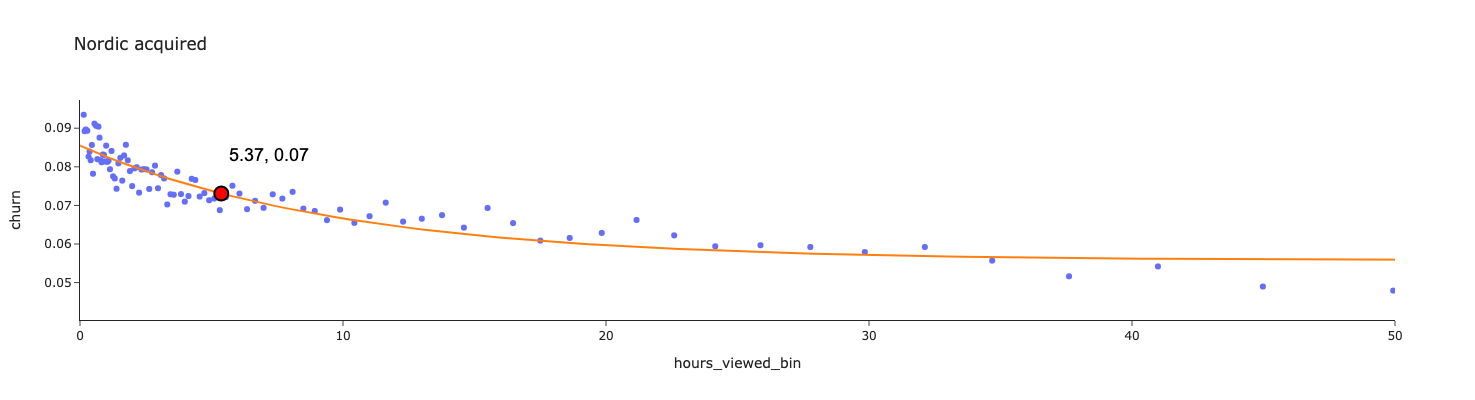

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1415,acquired,0.093488,9199,860,1303.810833
4,0.1765,acquired,0.089236,9402,839,1645.181389
7,0.2210,acquired,0.089666,8409,754,1851.533056
10,0.2765,acquired,0.089345,8484,758,2361.283333
13,0.3255,acquired,0.082652,8808,728,2878.087917


5.371388887749999
-0.0017430010821083508
y= 0.03 * e^(-0.10 * hours_viewed) + 0.06
y= -0.003 * e^(-0.10 * hours_viewed)


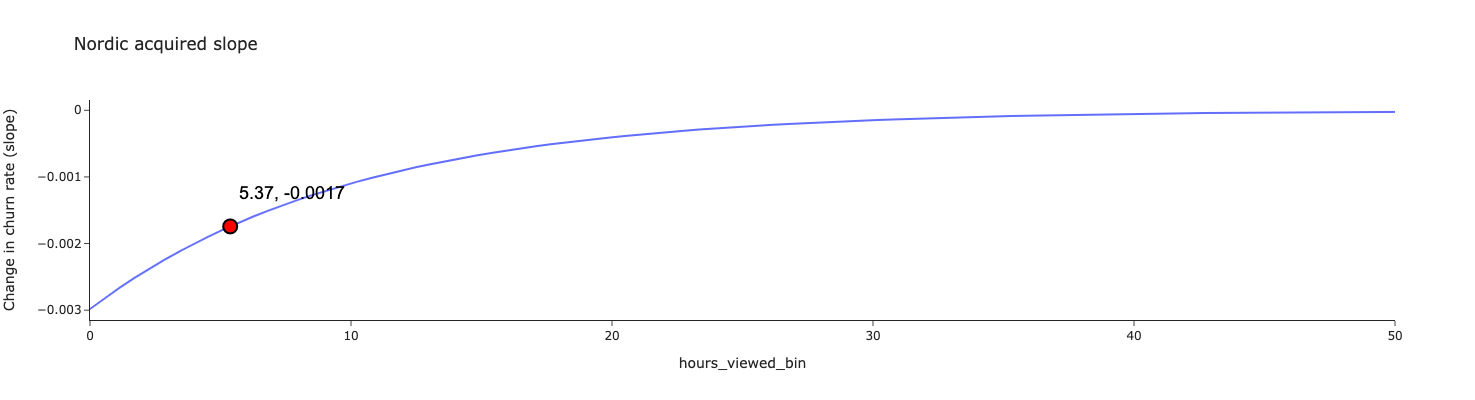

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1415,acquired,0.093488,9199,860,1303.810833
4,0.1765,acquired,0.089236,9402,839,1645.181389
7,0.2210,acquired,0.089666,8409,754,1851.533056
10,0.2765,acquired,0.089345,8484,758,2361.283333
13,0.3255,acquired,0.082652,8808,728,2878.087917


In [44]:
# ## Nordic   
# df_list = get_df_60_h([df_60_00, df_60_0, df_60_1, df_60_2])
# df_60 = pd.concat(df_list)
# Utils.to_pkl_s3(df_60,input_bucket, key_path, 'df_nor_o_2023.pkl')
df_60 = Utils.read_pkl_s3(input_bucket, key_path, 'df_nor_o_2023.pkl')

## Hours viewed 
print('hours viewed distribution')
df_60_user = df_60.groupby(by=['hbo_uuid','is_cancel','num_df','sub_month']).sum().reset_index()
display(df_60_user.describe())
# get_histogram(df_60_user[df_60_user.monthly_hours_viewed<=50].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution,total')

## hours viewed breakdown
print('hours viewed breakdown median')
df_60_pr = df_60.groupby(by=['hbo_uuid','sub_month','num_df','program_type']).sum().reset_index()
display(df_60_pr.groupby(by=['program_type']).median())
display(df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1]))

target_frc_list = [0.99, 0.9, 0.8, 0.7]
nor = []
for target_frc in target_frc_list:
    percentile = percentileofscore(df_60_pr[df_60_pr.program_type=='acquired']['frc'], target_frc)
    nor.append({'acquired_hr_fraction': target_frc, 'percentile': percentile})

## Average churn
print(df_60_user.shape, df_60_user.is_cancel.sum()/df_60_user.shape[0])

## Tenure churn
print('tenure churn')
df_60_month = df_60.groupby(by=['sub_month']).agg({'hbo_uuid':'count','is_cancel':'sum'})
df_60_month['churn'] = df_60_month['is_cancel'] /df_60_month['hbo_uuid'] 
display(df_60_month)

## some months have high churns (e.g. 17) investigate later 
df_60 = df_60[df_60.sub_month<=24]
 

## Total 
param_dic = {}
df_60_t = df_60.groupby(by=['hbo_uuid','is_cancel','sub_month']).sum().reset_index()
df_60_s = get_churn_bin(df_60_t, [])
param_dic = get_churn_plot_simple(df_60_s, 'total', param_dic)

## Acquired 
param_dic = {}
df_60_p= df_60.groupby(by=['hbo_uuid','is_cancel','sub_month','num_df','program_type']).sum().reset_index()

## Get median 
df_med= df_60_user[['hbo_uuid','sub_month','num_df']].merge(df_60_p[df_60_p.program_type=='acquired'], on=['hbo_uuid','sub_month','num_df'], how='left')
df_med = df_med.fillna(0)
med_x = df_med.monthly_hours_viewed.median()

df_60_s = df_60_p[df_60_p.frc>=0.99]
df_60_s = get_churn_bin(df_60_s, ['program_type'])
fig_nor, params = get_churn_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Nordic acquired', param_dic, np.array(med_x))
fig_nor_slope = get_churn_slope_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Nordic acquired slope', params, np.array(med_x))

df_nor = df_60_s[df_60_s.program_type=='acquired']

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_por_o_2023.pkl


hours viewed distribution


,num_df,sub_month,Unnamed: 0,hours_viewed,tenure_months,monthly_hours_viewed,frc
count,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000,111115.000000
mean,1.620690,6.431346,180204.070702,32.555886,18.125123,16.277943,0.999497
std,1.105078,2.959283,117796.084450,53.070818,13.582856,26.535409,0.016566
min,0.000000,3.000000,6.000000,0.250000,3.000000,0.125000,0.116107
25%,1.000000,4.000000,91194.000000,5.411389,9.000000,2.705694,1.000000
50%,2.000000,6.000000,159692.000000,15.785833,15.000000,7.892917,1.000000
75%,3.000000,8.000000,249792.500000,39.350278,24.000000,19.675139,1.000000
max,3.000000,20.000000,852291.000000,2135.045556,165.000000,1067.522778,1.000000


hours viewed breakdown median


,sub_month,num_df,Unnamed: 0,is_cancel,hours_viewed,tenure_months,monthly_hours_viewed,frc
program_type,,,,,,,,
0,6.0,3.0,64270.0,0.0,1.418333,6.0,0.709167,0.031421
acquired,6.0,2.0,128398.0,0.0,13.185000,12.0,6.592500,0.955556
original,6.0,1.0,66277.5,0.0,5.262222,6.0,2.631111,0.266849


,frc
count,104723.000000
mean,0.833645
std,0.231240
min,0.012822
10%,0.463748
20%,0.660897
25%,0.730656
30%,0.789511
40%,0.884185
50%,0.955556


(111115, 9) 0.11803986860459884
tenure churn


,hbo_uuid,is_cancel,churn
sub_month,,,
3,57698,8660,0.150092
4,48981,6419,0.131051
5,47531,5148,0.108308
6,32354,3291,0.101718
7,32232,2713,0.084171
8,21957,1580,0.071959
9,25528,1778,0.069649
10,15014,1069,0.071200
11,15725,1639,0.104229



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

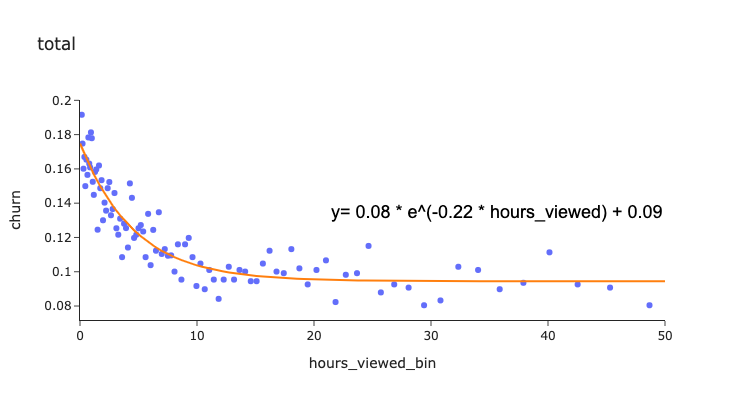

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1505,0.191589,1070,205,161.296250
1,0.2170,0.174766,1070,187,228.984167
2,0.2985,0.160112,1068,171,322.250556
3,0.3770,0.166978,1072,179,400.469444
4,0.4535,0.149953,1067,160,485.278750


5.8423611105
0.1347775841746174
y= 0.08 * e^(-0.13 * hours_viewed) + 0.10
y= -0.010 * e^(-0.13 * hours_viewed)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

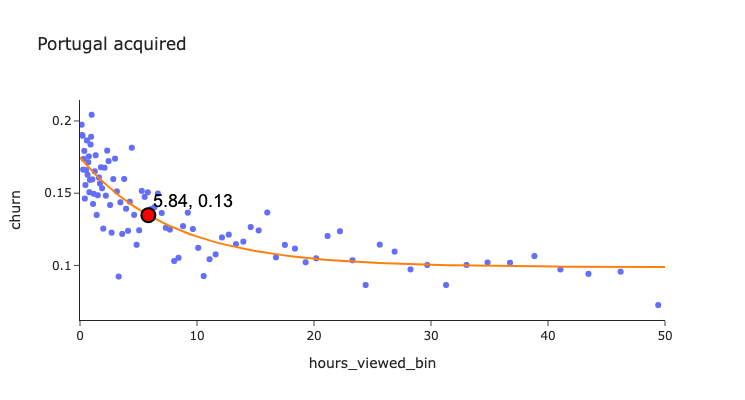

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1405,acquired,0.197417,542,107,76.101944
4,0.1730,acquired,0.190291,515,98,88.967361
6,0.2155,acquired,0.189765,469,89,100.823750
9,0.2695,acquired,0.166324,487,81,131.597222
11,0.3205,acquired,0.173737,495,86,159.359444


5.8423611105
-0.004598471503814154
y= 0.08 * e^(-0.13 * hours_viewed) + 0.10
y= -0.010 * e^(-0.13 * hours_viewed)


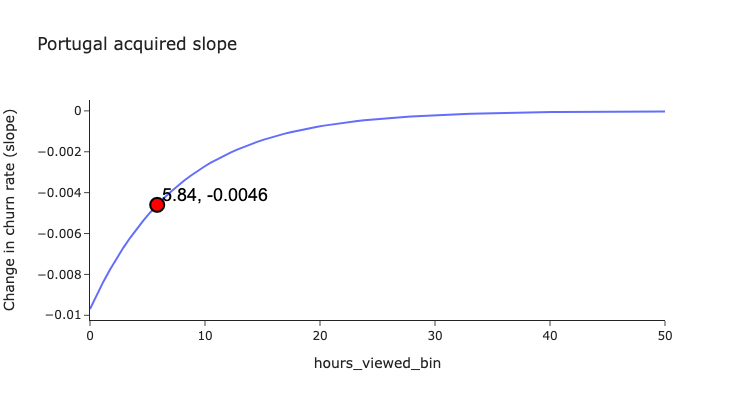

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1405,acquired,0.197417,542,107,76.101944
4,0.1730,acquired,0.190291,515,98,88.967361
6,0.2155,acquired,0.189765,469,89,100.823750
9,0.2695,acquired,0.166324,487,81,131.597222
11,0.3205,acquired,0.173737,495,86,159.359444


In [45]:
# ## Portugal   
# df_list = get_df_60_h([df_60_00, df_60_0, df_60_1, df_60_2])
# df_60 = pd.concat(df_list)
# Utils.to_pkl_s3(df_60,input_bucket, key_path, 'df_por_o_2023.pkl')
df_60 = Utils.read_pkl_s3(input_bucket, key_path, 'df_por_o_2023.pkl')

## Hours viewed 
print('hours viewed distribution')
df_60_user = df_60.groupby(by=['hbo_uuid','is_cancel','num_df','sub_month']).sum().reset_index()
display(df_60_user.describe())
# get_histogram(df_60_user[df_60_user.monthly_hours_viewed<=50].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution,total')

## hours viewed breakdown
print('hours viewed breakdown median')
df_60_pr = df_60.groupby(by=['hbo_uuid','sub_month','num_df','program_type']).sum().reset_index()
display(df_60_pr.groupby(by=['program_type']).median())
display(df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1]))

target_frc_list = [0.99, 0.9, 0.8, 0.7]
por = []
for target_frc in target_frc_list:
    percentile = percentileofscore(df_60_pr[df_60_pr.program_type=='acquired']['frc'], target_frc)
    por.append({'acquired_hr_fraction': target_frc, 'percentile': percentile})

## Average churn
print(df_60_user.shape, df_60_user.is_cancel.sum()/df_60_user.shape[0])

## Tenure churn
print('tenure churn')
df_60_month = df_60.groupby(by=['sub_month']).agg({'hbo_uuid':'count','is_cancel':'sum'})
df_60_month['churn'] = df_60_month['is_cancel'] /df_60_month['hbo_uuid'] 
display(df_60_month)

## some months have high churns (e.g. 17) investigate later 
df_60 = df_60[df_60.sub_month<=24]
 

## Total 
param_dic = {}
df_60_t = df_60.groupby(by=['hbo_uuid','is_cancel','sub_month']).sum().reset_index()
df_60_s = get_churn_bin(df_60_t, [])
param_dic = get_churn_plot_simple(df_60_s, 'total', param_dic)

## Acquired 
param_dic = {}
df_60_p= df_60.groupby(by=['hbo_uuid','is_cancel','sub_month','num_df','program_type']).sum().reset_index()

## Get median 
df_med= df_60_user[['hbo_uuid','sub_month','num_df']].merge(df_60_p[df_60_p.program_type=='acquired'], on=['hbo_uuid','sub_month','num_df'], how='left')
df_med = df_med.fillna(0)
med_x = df_med.monthly_hours_viewed.median()

df_60_s = df_60_p[df_60_p.frc>=0.9]
df_60_s = get_churn_bin(df_60_s, ['program_type'])
fig_por, params = get_churn_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Portugal acquired', param_dic, np.array(med_x))
fig_por_slope = get_churn_slope_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Portugal acquired slope', params, np.array(med_x))

df_por = df_60_s[df_60_s.program_type=='acquired']

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_spa_o_2023.pkl


hours viewed distribution


,num_df,sub_month,Unnamed: 0,hours_viewed,tenure_months,monthly_hours_viewed,frc
count,1.517333e+06,1.517333e+06,1.517333e+06,1.517333e+06,1.517333e+06,1.517333e+06,1.517333e+06
mean,1.496474e+00,1.197619e+01,2.244972e+06,3.299403e+01,3.651253e+01,1.649701e+01,9.996906e-01
std,1.115000e+00,5.677048e+00,1.369483e+06,4.930798e+01,2.669113e+01,2.465399e+01,1.344037e-02
min,0.000000e+00,3.000000e+00,0.000000e+00,2.500000e-01,3.000000e+00,1.250000e-01,2.326632e-03
25%,0.000000e+00,6.000000e+00,1.189305e+06,6.864722e+00,1.600000e+01,3.432361e+00,1.000000e+00
50%,2.000000e+00,1.400000e+01,2.064072e+06,1.763750e+01,3.000000e+01,8.818750e+00,1.000000e+00
75%,2.000000e+00,1.600000e+01,3.117865e+06,3.984083e+01,5.400000e+01,1.992042e+01,1.000000e+00
max,3.000000e+00,2.100000e+01,1.188835e+07,2.318282e+03,2.310000e+02,1.159141e+03,1.000000e+00


hours viewed breakdown median


,sub_month,num_df,Unnamed: 0,is_cancel,hours_viewed,tenure_months,monthly_hours_viewed,frc
program_type,,,,,,,,
0,14.0,1.0,768973.0,0.0,1.615000,14.0,0.807500,0.049127
acquired,14.0,2.0,1611380.0,0.0,13.865278,21.0,6.932639,0.898742
original,14.0,1.0,747705.5,0.0,6.073333,14.0,3.036667,0.275047


,frc
count,1.438600e+06
mean,8.015082e-01
std,2.397299e-01
min,2.326632e-03
10%,4.231950e-01
20%,6.030463e-01
25%,6.695188e-01
30%,7.264646e-01
40%,8.211308e-01
50%,8.987419e-01


(1517333, 9) 0.06613841523251653
tenure churn


,hbo_uuid,is_cancel,churn
sub_month,,,
3,368760,52634,0.142732
4,339814,40606,0.119495
5,312865,33215,0.106164
6,234379,22974,0.098021
7,208825,17272,0.082710
8,154357,11334,0.073427
9,166049,12189,0.073406
10,124709,8661,0.069450
11,131771,11287,0.085656



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

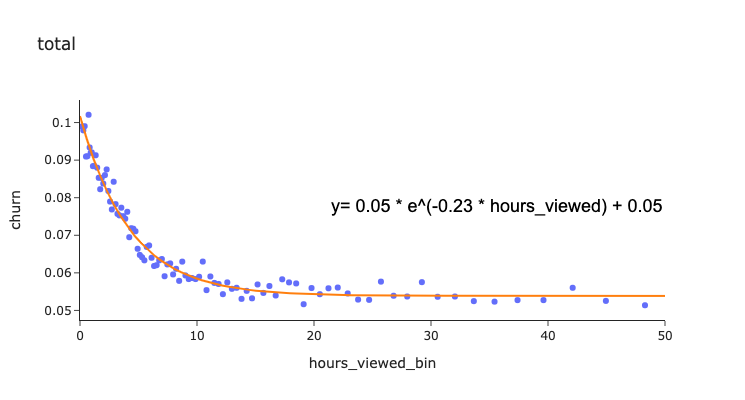

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1720,0.098969,14641,1449,2470.422222
1,0.2835,0.097925,14654,1435,4233.495278
2,0.3990,0.099022,14623,1448,5804.947222
3,0.5120,0.090959,14633,1331,7401.850972
4,0.6295,0.091039,14642,1333,9307.484722



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

6.2784722214999995
0.08413192074496659
y= 0.04 * e^(-0.10 * hours_viewed) + 0.06
y= -0.004 * e^(-0.10 * hours_viewed)


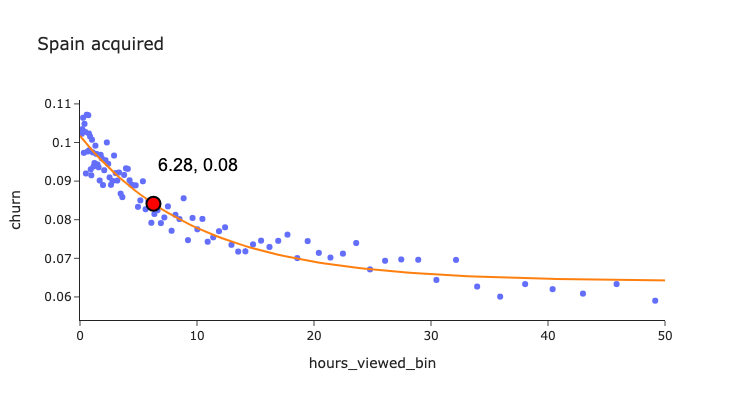

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1470,acquired,0.102250,5956,609,879.166667
4,0.1980,acquired,0.103448,5684,588,1104.362083
7,0.2645,acquired,0.106409,5648,601,1493.845694
10,0.3290,acquired,0.097322,5415,527,1791.157639
13,0.3855,acquired,0.104831,5113,536,1968.258056


6.2784722214999995
-0.002012614324233604
y= 0.04 * e^(-0.10 * hours_viewed) + 0.06
y= -0.004 * e^(-0.10 * hours_viewed)


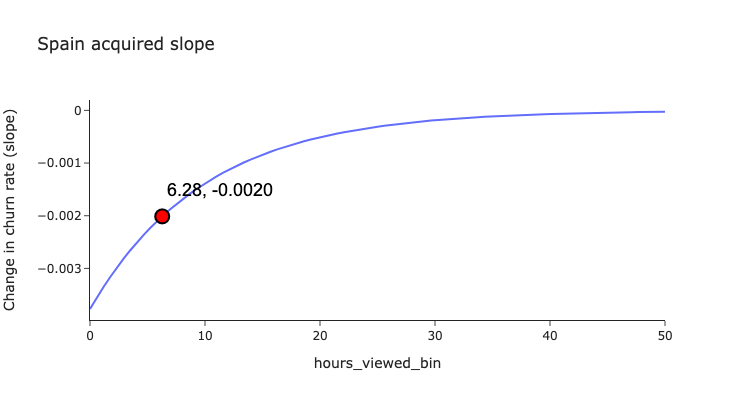

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1470,acquired,0.102250,5956,609,879.166667
4,0.1980,acquired,0.103448,5684,588,1104.362083
7,0.2645,acquired,0.106409,5648,601,1493.845694
10,0.3290,acquired,0.097322,5415,527,1791.157639
13,0.3855,acquired,0.104831,5113,536,1968.258056


In [46]:
# ## SPA  
# df_list = get_df_60_h([df_60_00, df_60_0, df_60_1, df_60_2])
# df_60 = pd.concat(df_list)
# Utils.to_pkl_s3(df_60,input_bucket, key_path, 'df_spa_o_2023.pkl')
df_60 = Utils.read_pkl_s3(input_bucket, key_path, 'df_spa_o_2023.pkl')

## Hours viewed 
print('hours viewed distribution')
df_60_user = df_60.groupby(by=['hbo_uuid','is_cancel','num_df','sub_month']).sum().reset_index()
display(df_60_user.describe())
# get_histogram(df_60_user[df_60_user.monthly_hours_viewed<=50].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution,total')

## hours viewed breakdown
print('hours viewed breakdown median')
df_60_pr = df_60.groupby(by=['hbo_uuid','sub_month','num_df','program_type']).sum().reset_index()
spa = df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1])
display(df_60_pr.groupby(by=['program_type']).median())
display(df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1]))

target_frc_list = [0.99, 0.9, 0.8, 0.7]
spa = []
for target_frc in target_frc_list:
    percentile = percentileofscore(df_60_pr[df_60_pr.program_type=='acquired']['frc'], target_frc)
    spa.append({'acquired_hr_fraction': target_frc, 'percentile': percentile})


## Average churn
print(df_60_user.shape, df_60_user.is_cancel.sum()/df_60_user.shape[0])

## Tenure churn
print('tenure churn')
df_60_month = df_60.groupby(by=['sub_month']).agg({'hbo_uuid':'count','is_cancel':'sum'})
df_60_month['churn'] = df_60_month['is_cancel'] /df_60_month['hbo_uuid'] 
display(df_60_month)

## some months have high churns (e.g. 17) investigate later 
df_60 = df_60[df_60.sub_month<=24]
 

## Total 
param_dic = {}
df_60_t = df_60.groupby(by=['hbo_uuid','is_cancel','sub_month']).sum().reset_index()
df_60_s = get_churn_bin(df_60_t, [])
param_dic = get_churn_plot_simple(df_60_s, 'total', param_dic)

## Acquired 
param_dic = {}
df_60_p= df_60.groupby(by=['hbo_uuid','is_cancel','sub_month','num_df','program_type']).sum().reset_index()

## Get median 
df_med= df_60_user[['hbo_uuid','sub_month','num_df']].merge(df_60_p[df_60_p.program_type=='acquired'], on=['hbo_uuid','sub_month','num_df'], how='left')
df_med = df_med.fillna(0)
med_x = df_med.monthly_hours_viewed.median()

df_60_s = df_60_p[df_60_p.frc>=0.9]
df_60_s = get_churn_bin(df_60_s, ['program_type'])
fig_spa, params = get_churn_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Spain acquired', param_dic, np.array(med_x))
fig_spa_slope = get_churn_slope_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Spain acquired slope', params, np.array(med_x))

df_spa = df_60_s[df_60_s.program_type=='acquired']

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_neth_o_2023.pkl


hours viewed distribution


,num_df,sub_month,Unnamed: 0,hours_viewed,tenure_months,monthly_hours_viewed,frc
count,239390.000000,239390.000000,2.393900e+05,239390.000000,239390.000000,239390.000000,239390.000000
mean,1.664000,7.043110,3.033828e+05,30.159461,18.272576,15.079731,0.999770
std,1.093842,3.221892,1.978248e+05,47.959901,13.407988,23.979951,0.011792
min,0.000000,3.000000,3.000000e+00,0.250000,3.000000,0.125000,0.041851
25%,1.000000,4.000000,1.562265e+05,5.399792,9.000000,2.699896,1.000000
50%,2.000000,6.000000,2.660840e+05,15.093056,15.000000,7.546528,1.000000
75%,3.000000,9.000000,4.194770e+05,36.715764,24.000000,18.357882,1.000000
max,3.000000,20.000000,1.581245e+06,1927.662222,144.000000,963.831111,1.000000


hours viewed breakdown median


,sub_month,num_df,Unnamed: 0,is_cancel,hours_viewed,tenure_months,monthly_hours_viewed,frc
program_type,,,,,,,,
0,6.0,0.0,115811.0,0.0,1.011667,6.0,0.505833,0.027891
acquired,6.0,2.0,218752.5,0.0,12.867361,12.0,6.433681,0.992631
original,6.0,2.0,120005.0,0.0,5.055556,7.0,2.527778,0.266294


,frc
count,226636.000000
mean,0.851933
std,0.223694
min,0.009666
10%,0.493846
20%,0.696280
25%,0.766912
30%,0.827369
40%,0.921336
50%,0.992631


(239390, 9) 0.051673002213960484
tenure churn


,hbo_uuid,is_cancel,churn
sub_month,,,
3,91684,7737,0.084388
4,91556,5820,0.063568
5,78943,4095,0.051873
6,67837,2916,0.042985
7,60497,2204,0.036432
8,48121,1602,0.033291
9,54696,1466,0.026803
10,36541,1020,0.027914
11,38745,914,0.023590



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

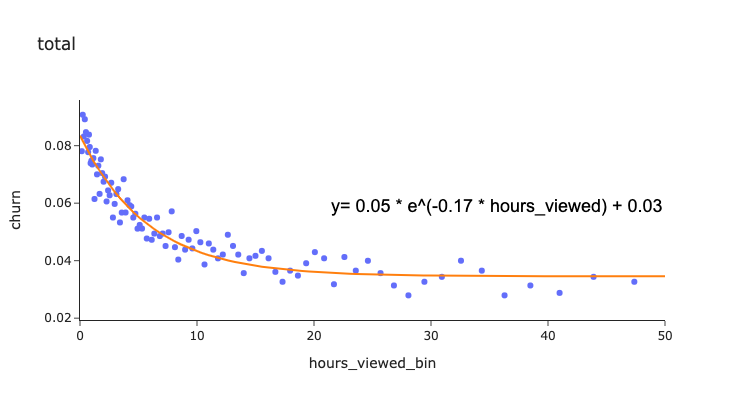

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1535,0.078078,2331,182,360.570556
1,0.2350,0.090753,2325,211,540.692778
2,0.3245,0.083190,2332,194,767.960694
3,0.4110,0.089186,2321,207,955.947083
4,0.5080,0.084695,2326,197,1177.259306


5.74819444475
0.058561927372957
y= 0.04 * e^(-0.12 * hours_viewed) + 0.04
y= -0.005 * e^(-0.12 * hours_viewed)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

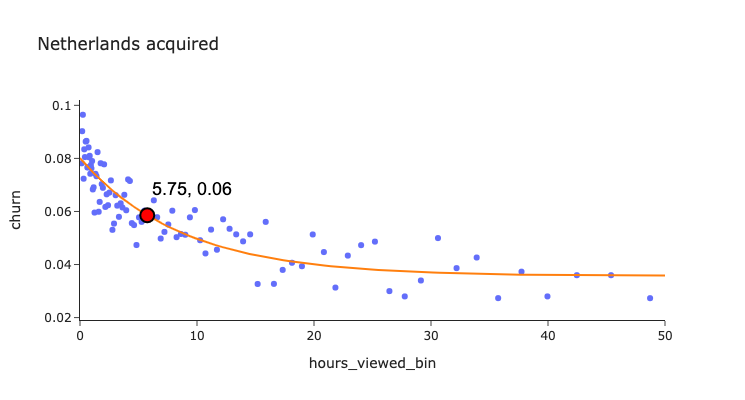

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1440,acquired,0.078150,1254,98,181.202222
3,0.1870,acquired,0.090256,1252,113,228.747500
5,0.2450,acquired,0.096451,1099,106,267.985694
7,0.3095,acquired,0.072347,1244,90,388.847222
9,0.3620,acquired,0.083426,899,75,323.450556


5.74819444475
-0.0026410678139254856
y= 0.04 * e^(-0.12 * hours_viewed) + 0.04
y= -0.005 * e^(-0.12 * hours_viewed)


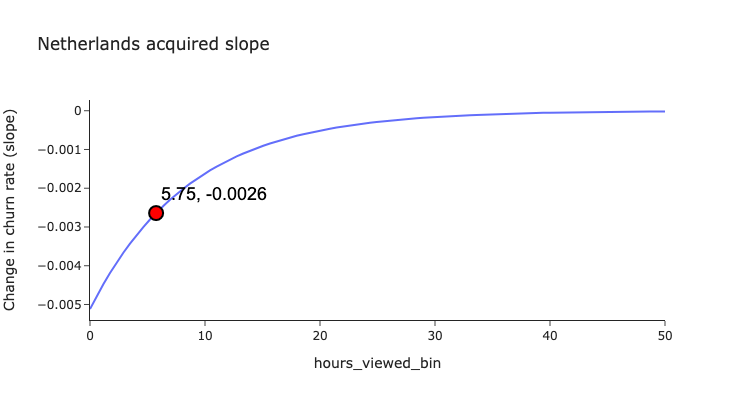

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1440,acquired,0.078150,1254,98,181.202222
3,0.1870,acquired,0.090256,1252,113,228.747500
5,0.2450,acquired,0.096451,1099,106,267.985694
7,0.3095,acquired,0.072347,1244,90,388.847222
9,0.3620,acquired,0.083426,899,75,323.450556


In [47]:
# ## NETH  
# df_list = get_df_60_h([df_60_00, df_60_0, df_60_1, df_60_2])
# df_60 = pd.concat(df_list)
# Utils.to_pkl_s3(df_60,input_bucket, key_path, 'df_neth_o_2023.pkl')
df_60 = Utils.read_pkl_s3(input_bucket, key_path, 'df_neth_o_2023.pkl')

## Hours viewed 
print('hours viewed distribution')
df_60_user = df_60.groupby(by=['hbo_uuid','is_cancel','num_df','sub_month']).sum().reset_index()
display(df_60_user.describe())
# get_histogram(df_60_user[df_60_user.monthly_hours_viewed<=50].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution,total')

## hours viewed breakdown
print('hours viewed breakdown median')
df_60_pr = df_60.groupby(by=['hbo_uuid','sub_month','num_df','program_type']).sum().reset_index()
neth = df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1])
display(df_60_pr.groupby(by=['program_type']).median())
display(df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1.0]))

target_frc_list = [0.99, 0.9, 0.8, 0.7]
neth = []
for target_frc in target_frc_list:
    percentile = percentileofscore(df_60_pr[df_60_pr.program_type=='acquired']['frc'], target_frc)
    neth.append({'acquired_hr_fraction': target_frc, 'percentile': percentile})


## Average churn
print(df_60_user.shape, df_60_user.is_cancel.sum()/df_60_user.shape[0])

## Tenure churn
print('tenure churn')
df_60_month = df_60.groupby(by=['sub_month']).agg({'hbo_uuid':'count','is_cancel':'sum'})
df_60_month['churn'] = df_60_month['is_cancel'] /df_60_month['hbo_uuid'] 
display(df_60_month)

## some months have high churns (e.g. 17) investigate later 
df_60 = df_60[df_60.sub_month<=24]



## NETH 

## Total 
param_dic = {}
df_60_t = df_60.groupby(by=['hbo_uuid','is_cancel','sub_month']).sum().reset_index()
df_60_s = get_churn_bin(df_60_t, [])
param_dic = get_churn_plot_simple(df_60_s, 'total', param_dic)

## Acquired 
param_dic = {}
df_60_p= df_60.groupby(by=['hbo_uuid','is_cancel','sub_month','num_df','program_type']).sum().reset_index()

## Get median 
df_med= df_60_user[['hbo_uuid','sub_month','num_df']].merge(df_60_p[df_60_p.program_type=='acquired'], on=['hbo_uuid','sub_month','num_df'], how='left')
df_med = df_med.fillna(0)
med_x = df_med.monthly_hours_viewed.median()

df_60_s = df_60_p[df_60_p.frc>=0.9]
df_60_s = get_churn_bin(df_60_s, ['program_type'])
fig_neth, params = get_churn_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Netherlands acquired', param_dic, np.array(med_x))
fig_neth_slope = get_churn_slope_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Netherlands acquired slope', params, np.array(med_x))

df_neth = df_60_s[df_60_s.program_type=='acquired']

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_ce_o_2023.pkl


hours viewed distribution


,num_df,sub_month,Unnamed: 0,hours_viewed,tenure_months,monthly_hours_viewed,frc
count,1.019105e+06,1.019105e+06,1.019105e+06,1.019105e+06,1.019105e+06,1.019105e+06,1.019105e+06
mean,1.663025e+00,6.564316e+00,2.042085e+06,4.056044e+01,2.064412e+01,2.028022e+01,9.995860e-01
std,1.096298e+00,3.047470e+00,1.269252e+06,6.353400e+01,1.502607e+01,3.176700e+01,1.558022e-02
min,0.000000e+00,3.000000e+00,0.000000e+00,2.500000e-01,3.000000e+00,1.250000e-01,4.373890e-03
25%,1.000000e+00,4.000000e+00,1.063340e+06,6.951667e+00,1.000000e+01,3.475833e+00,1.000000e+00
50%,2.000000e+00,6.000000e+00,1.861350e+06,1.993917e+01,1.600000e+01,9.969583e+00,1.000000e+00
75%,3.000000e+00,9.000000e+00,2.832559e+06,4.949639e+01,2.700000e+01,2.474819e+01,1.000000e+00
max,3.000000e+00,1.900000e+01,1.143641e+07,9.648768e+03,1.600000e+02,4.824384e+03,1.000000e+00


hours viewed breakdown median


,sub_month,num_df,Unnamed: 0,is_cancel,hours_viewed,tenure_months,monthly_hours_viewed,frc
program_type,,,,,,,,
0,5.0,1.0,648573.5,0.0,1.612917,5.0,0.806458,0.029590
acquired,6.0,2.0,1546401.0,0.0,17.478333,14.0,8.739167,0.981194
original,6.0,2.0,671194.0,0.0,5.036667,6.0,2.518333,0.187084


,frc
count,986169.000000
mean,0.870895
std,0.200295
min,0.004374
10%,0.568943
20%,0.753048
25%,0.812208
30%,0.859212
40%,0.929870
50%,0.981194


(1019105, 9) 0.08935683761732108
tenure churn


,hbo_uuid,is_cancel,churn
sub_month,,,
3,561537,74018,0.131813
4,512424,53312,0.104039
5,433208,37625,0.086852
6,369090,27296,0.073955
7,303812,20451,0.067315
8,244899,14815,0.060494
9,249514,13635,0.054646
10,165292,8154,0.049331
11,161018,7274,0.045175



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

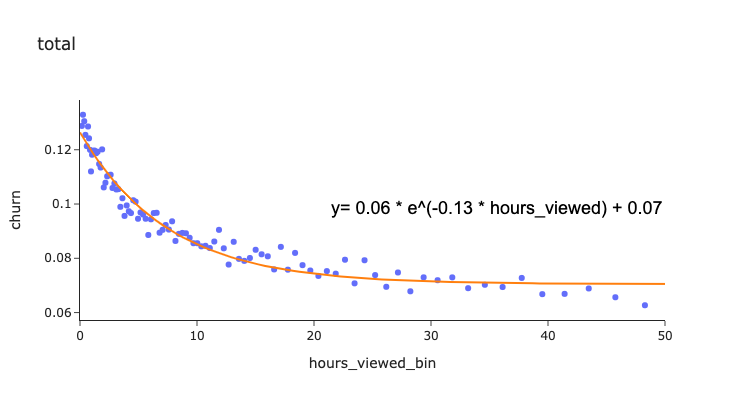

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1595,0.128772,9544,1229,1510.681944
1,0.2550,0.132893,9534,1267,2442.230417
2,0.3615,0.130517,9539,1245,3414.490556
3,0.4625,0.125472,9540,1197,4408.699583
4,0.5795,0.121342,9535,1157,5538.088472



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

8.183333333499998
0.09674835599113918
y= 0.05 * e^(-0.10 * hours_viewed) + 0.07
y= -0.005 * e^(-0.10 * hours_viewed)


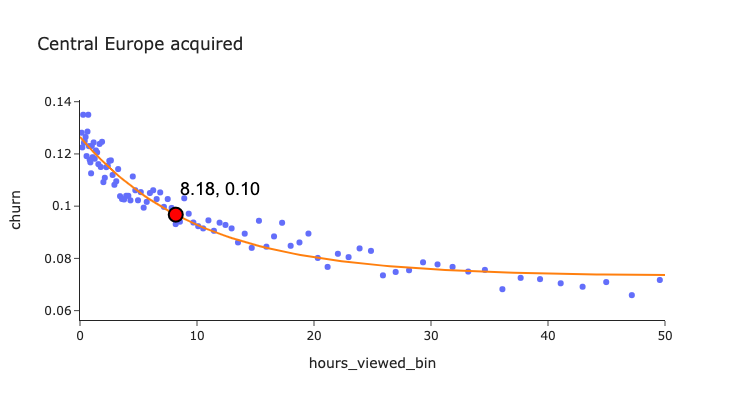

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1465,acquired,0.128113,5300,679,778.009722
4,0.2000,acquired,0.122500,5200,637,1011.004583
7,0.2710,acquired,0.135000,5000,675,1366.419444
10,0.3370,acquired,0.124249,4330,538,1460.112778
13,0.4020,acquired,0.124946,4658,582,1875.350139


8.183333333499998
-0.0023521051465180748
y= 0.05 * e^(-0.10 * hours_viewed) + 0.07
y= -0.005 * e^(-0.10 * hours_viewed)


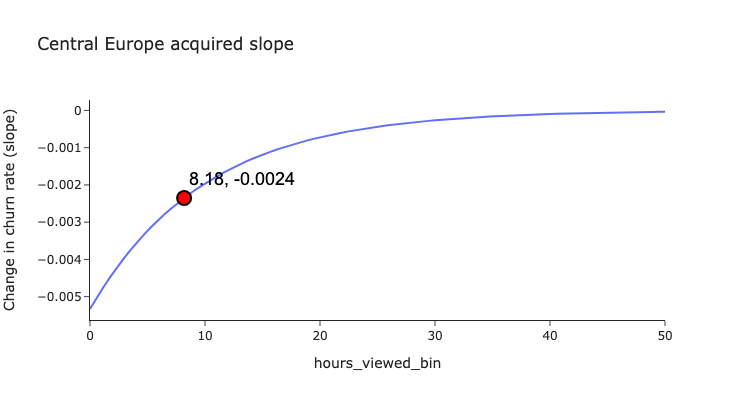

,hours_viewed_bin,program_type,churn,hbo_uuid,is_cancel,monthly_hours_viewed
1,0.1465,acquired,0.128113,5300,679,778.009722
4,0.2000,acquired,0.122500,5200,637,1011.004583
7,0.2710,acquired,0.135000,5000,675,1366.419444
10,0.3370,acquired,0.124249,4330,538,1460.112778
13,0.4020,acquired,0.124946,4658,582,1875.350139


In [48]:
# ## CEU  
# df_list = get_df_60_h([df_60_00, df_60_0, df_60_1, df_60_2])
# df_60 = pd.concat(df_list)
# Utils.to_pkl_s3(df_60,input_bucket, key_path, 'df_ce_o_2023.pkl')
df_60 = Utils.read_pkl_s3(input_bucket, key_path, 'df_ce_o_2023.pkl')

## Hours viewed 
print('hours viewed distribution')
df_60_user = df_60.groupby(by=['hbo_uuid','is_cancel','num_df','sub_month']).sum().reset_index()
display(df_60_user.describe())
# get_histogram(df_60_user[df_60_user.monthly_hours_viewed<=50].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution,total')

## hours viewed breakdown
print('hours viewed breakdown median')
df_60_pr = df_60.groupby(by=['hbo_uuid','sub_month','num_df','program_type']).sum().reset_index()
ce = df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1])
display(df_60_pr.groupby(by=['program_type']).median())
display(df_60_pr[['frc']][df_60_pr.program_type=='acquired'].describe(percentiles=[0.1,0.2,0.25,0.3,0.4,0.5,0.75,1]))

target_frc_list = [0.99, 0.9, 0.8, 0.7]
ce = []
for target_frc in target_frc_list:
    percentile = percentileofscore(df_60_pr[df_60_pr.program_type=='acquired']['frc'], target_frc)
    ce.append({'acquired_hr_fraction': target_frc, 'percentile': percentile})


## Average churn
print(df_60_user.shape, df_60_user.is_cancel.sum()/df_60_user.shape[0])

## Tenure churn
print('tenure churn')
df_60_month = df_60.groupby(by=['sub_month']).agg({'hbo_uuid':'count','is_cancel':'sum'})
df_60_month['churn'] = df_60_month['is_cancel'] /df_60_month['hbo_uuid'] 
display(df_60_month)

## some months have high churns (e.g. 17) investigate later 
df_60 = df_60[df_60.sub_month<=24]


## CEU 

## Total 
param_dic = {}
df_60_t = df_60.groupby(by=['hbo_uuid','is_cancel','sub_month']).sum().reset_index()
df_60_s = get_churn_bin(df_60_t, [])
param_dic = get_churn_plot_simple(df_60_s, 'total', param_dic)

## Acquired 
param_dic = {}
df_60_p= df_60.groupby(by=['hbo_uuid','is_cancel','sub_month','num_df','program_type']).sum().reset_index()

## Get median 
df_med= df_60_user[['hbo_uuid','sub_month','num_df']].merge(df_60_p[df_60_p.program_type=='acquired'], on=['hbo_uuid','sub_month', 'num_df'], how='left')
df_med = df_med.fillna(0)
med_x = df_med.monthly_hours_viewed.median()

df_60_s = df_60_p[df_60_p.frc>=0.9]
df_60_s = get_churn_bin(df_60_s, ['program_type'])
fig_ce, params = get_churn_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Central Europe acquired', param_dic, np.array(med_x))
fig_ce_slope = get_churn_slope_plot_simple(df_60_s[df_60_s.program_type=='acquired'], 'Central Europe acquired slope', params, np.array(med_x))

df_ce = df_60_s[df_60_s.program_type=='acquired']